<a href="https://colab.research.google.com/github/katrin2202/text-summarization-in-nlp/blob/main/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#BERT для задачи суммирования текстовых данных

In [1]:
#@title Загрузка нужных библиотек
%%capture
!pip install datasets
!pip install transformers

In [2]:
#@title Авторизация на сайте HuggingFace
# Ввести свой ключ huggingface hyb
from huggingface_hub import notebook_login
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


## Загрузка и подготовка dataset

In [3]:
#@title Загрузка личного датасета `Katerina-gopher/ru-summary`
%%capture
from datasets import load_dataset

# If the dataset is gated/private, make sure you have run huggingface-cli login
dataset = load_dataset("Katerina-gopher/ru-summary")

In [4]:
#@title Структура dataset
dataset

DatasetDict({
    train: Dataset({
        features: ['summ', 'text'],
        num_rows: 121833
    })
    test: Dataset({
        features: ['summ', 'text'],
        num_rows: 17512
    })
    validation: Dataset({
        features: ['summ', 'text'],
        num_rows: 12103
    })
})

In [ ]:
#@title Выведим первую запись `dataset['train']`
dataset['train'][0]

In [4]:
#@title Загрузка стоп слов
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words("russian"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
#@title Функция очистки текстов и результатов
from bs4 import BeautifulSoup
import re

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    # newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Zа-яА-Я]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [7]:
#@title Очистка данных text
cleaned_text = []
i = 0
for t in dataset['train']['text']:
    cleaned_text.append(text_cleaner(t,0))
    if i < 10000:
      i += 1
    else:
      break
# cleaned_text[:5]  

<ipython-input-5-fd776a4ee5d0>:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  newString = BeautifulSoup(newString, "lxml").text


In [8]:
#@title Очистка данных summ
cleaned_summary = []
i = 0
for t in dataset['train']['summ']:
    cleaned_summary.append(text_cleaner(t,1))
    if i < 10000:
      i += 1
    else:
      break
# cleaned_summary[:5]

<ipython-input-5-fd776a4ee5d0>:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  newString = BeautifulSoup(newString, "lxml").text


In [9]:
#@title Дабавляем очищенные данные в датасет
dataset['cleaned_text']=cleaned_text
dataset['cleaned_summary']=cleaned_summary

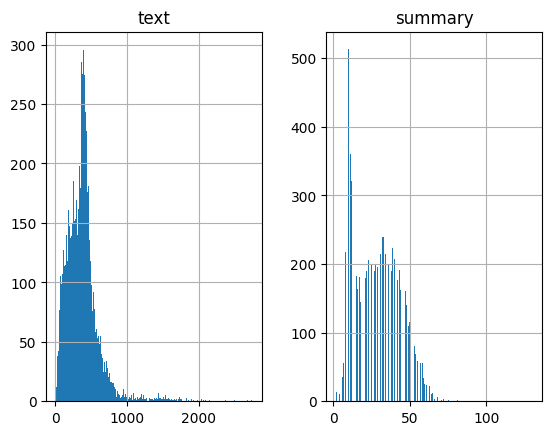

In [10]:
#@title Визуализация данных
import matplotlib.pyplot as plt
import pandas as pd

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in dataset['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in dataset['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 300)
plt.show()

In [11]:
#@title Процент обобщенного текста в котором меньше 25 слов
cnt=0
for i in dataset['cleaned_summary']:
    if(len(i.split())<=100):
        cnt=cnt+1
print(round(cnt/len(dataset['cleaned_summary'])*10000) / 100)

99.93


In [12]:
from transformers.utils.dummy_pt_objects import BridgeTowerForMaskedLM
#@title Процент исходного текста меньше 100 слов
cnt=0
for s in dataset['cleaned_text']:
    if(len(s.split())<=512):
        cnt=cnt+1
print(round(cnt/len(dataset['cleaned_text'])*10000) / 100)

82.59


In [13]:
#@title Максимальная длина текста
max_text_len=512
max_summary_len=100

In [14]:
#@title Избавимся от выборосов
# import numpy as np

cleaned_text =dataset['cleaned_text']
cleaned_summary=dataset['cleaned_summary']

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

dataset['short_text']=short_text
dataset['short_summary']=short_summary        
# df=pd.DataFrame({'text':short_text,'summary':short_summary})

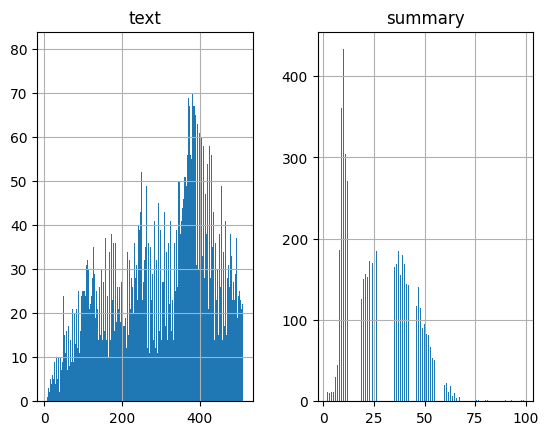

In [15]:
#@title Визуализация данных
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in dataset['short_text']:
      text_word_count.append(len(i.split()))

for i in dataset['short_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 300)
plt.show()

In [16]:
from transformers import AutoTokenizer

checkpoint = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenized_text = tokenizer(dataset['short_text'])
tokenized_summary = tokenizer(dataset["short_summary"])

Token indices sequence length is longer than the specified maximum sequence length for this model (653 > 512). Running this sequence through the model will result in indexing errors


## Загрузка и обучение модели Bert

In [10]:
#@title Для нашей задачи используем преобученную модель `bert-base-multilingual-cased`
from transformers import BertModel

model = BertModel.from_pretrained("bert-base-multilingual-cased")

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
#@title Структура модели
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
#@title Для скачивания модели используется команда
model.save_pretrained("directory_on_my_computer")